# HW1

### Kaggle ID: Jose Fernandez

In [2]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import io

if __name__ == "__main__":
    for data_name in ["mnist", "spam", "toy"]:
        data = np.load(f"/Users/jose/Downloads/hw1/data/{data_name}-data.npz")  
        print("\nloaded %s data!" % data_name)
        fields = "test_data", "training_data", "training_labels"
        for field in fields:
            print(field, data[field].shape)
        if data_name == "toy":
            toy_training_data = data["training_data"]
            toy_training_labels = data["training_labels"]
        if data_name == "mnist":
            mnist_training_data = data["training_data"]
            mnist_test_data = data["test_data"]
            mnist_training_labels = data["training_labels"]
        if data_name == "spam":
            spam_training_data = data["training_data"]
            spam_test_data = data["test_data"]
            spam_training_labels = data["training_labels"]
from sklearn.svm import SVC
from sklearn.svm import LinearSVC


loaded mnist data!
test_data (10000, 1, 28, 28)
training_data (60000, 1, 28, 28)
training_labels (60000,)

loaded spam data!
test_data (1000, 37)
training_data (4171, 37)
training_labels (4171,)

loaded toy data!
test_data (0,)
training_data (1000, 2)
training_labels (1000,)


### Problem 2, part e

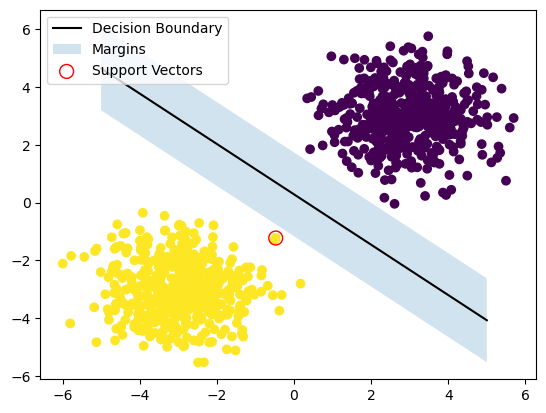

In [2]:
plt.scatter(toy_training_data[:, 0], toy_training_data[:, 1], c=toy_training_labels)
w = np.array([-0.4528, -0.5190])  # Convert to NumPy array
alpha = 0.1471
# Plot the decision boundary
x = np.linspace(-5, 5, 100)
y = -(w[0] * x + alpha) / w[1]
plt.plot(x, y, 'k', label='Decision Boundary')

# Plot the margins
margin = 1 / np.sqrt(np.sum(w**2))  # Calculate margin
plt.fill_between(x, y - margin, y + margin, alpha=0.2, label='Margins')

# Plot and label support vectors
support_vectors = toy_training_data[(w.dot(toy_training_data.T) + alpha * toy_training_labels <= 1)
                                   & (w.dot(toy_training_data.T) + alpha * toy_training_labels >= -1)]
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], 
            marker='o', facecolors='none', edgecolors='r', s=100, label='Support Vectors')

plt.legend()
plt.show()

#### We can see in the graph above, the support vectors fall along the lines of the margins.

### Problem 3: Data Partitioning and Evaluation Metrics

#### Part A: I imported random and used it to partition my data given a set of labels and the amount of times the data is to be shuffled. I used 10,000 for MNIST and 20% of total for spam.

In [3]:
import random 
def data_partition(data, labels, number):
    assert len(data) == len(labels)
    data, labels = list(data), list(labels)
    idx = range(len(data))
    random_idx = random.sample(idx, number)
    random_data = [data[i] for i in random_idx]
    random_label = [labels[i] for i in random_idx]
    return (random_data, random_label)
#MNIST
mnist_data_shuffled, mnist_labels_shuffled = data_partition(mnist_training_data,
                                                                   mnist_training_labels, 10000)
#SPAM
spam_data_shuffled, spam_labels_shuffled = data_partition(spam_training_data,
                                                                 spam_training_labels,
                                                                 int(len(spam_training_data)*.2))

#### Part B: Made functions to calculate accuracy given the formula in the question as well as the evaluation metric that can fit multiple accuracies based on sizes and models used. 

In [4]:
from sklearn import metrics
# evaluation metric taking true labels y, and predicted labels y_hat to compute unweighted accuracy score, s
def calculate_accuracy(predictions, labels):
    correct = sum(1 for pred, label in zip(predictions, labels) if pred == label)
    total = len(predictions)
    accuracy = correct / total
    return accuracy
def evaluation_metric(models, model_sizes, data, labels):
    accuracy = []
    print("Training Data Size, Model Accuracy")
    for i, size in enumerate(model_sizes):
        predictions = models[i].predict(data)
        print(size, calculate_accuracy(predictions, labels))
        accuracy.append(calculate_accuracy(predictions, labels))
    return accuracy

### Problem 4: Support Vector Machines: Coding

In [5]:
# Trains models using data and labels
# Returns a list of models based on the sizes of our training data.
def train_models(data, labels, model_sizes):
    model = model_sizes.copy()
    for i, size in enumerate(model_sizes):
        training_data, training_labels = data_partition(data,
           labels, size)
        model[i] = svm.SVC()
        model[i].fit(training_data, training_labels)
    return model

#### Part A: MNIST

In [13]:
mnist_sizes = [100, 200, 500, 1000, 2000, 5000, 10000]
mnist_training_data_flattened = mnist_training_data.reshape(mnist_training_data.shape[0], -1)

mnist_model = train_models(mnist_training_data_flattened, mnist_training_labels, mnist_sizes)
evaluation_metric(mnist_model, mnist_sizes, mnist_training_data_flattened, mnist_training_labels)

Training Data Size, Model Accuracy
100 0.6719666666666667
200 0.8275666666666667
500 0.8849166666666667
1000 0.9147833333333333
2000 0.9357166666666666
5000 0.9546666666666667
10000 0.9645166666666667


[0.6719666666666667,
 0.8275666666666667,
 0.8849166666666667,
 0.9147833333333333,
 0.9357166666666666,
 0.9546666666666667,
 0.9645166666666667]

#### Part B: Spam

In [15]:
spam_sizes = [100, 200, 500, 1000, 2000, 4171]
spam_training_model = train_models(spam_training_data, spam_training_labels, spam_sizes)
spam_training_accuracy = evaluation_metric(spam_training_model, spam_sizes, spam_training_data, spam_training_labels)

Training Data Size, Model Accuracy
100 0.6943179093742508
200 0.7144569647566531
500 0.7146967154159674
1000 0.7166147206904819
2000 0.7163749700311676
4171 0.7168544713497962


### Problem 5: Hyperparameter Tuning

In [6]:
def hyperparameter_model(data, labels, c_values):
    model = c_values.copy()
    for i, val in enumerate(c_values):
        training_data, training_labels = data_partition(data, labels, 10000)
        
        # Flatten each image in the list
        training_data_flattened = [img.flatten() for img in training_data]

        model[i] = svm.SVC(C=val)
        model[i].fit(training_data_flattened, training_labels)
        print("Model", i, "complete")
    return model


In [17]:
c_values = [0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 500, 1000]
hyperparameter_test = hyperparameter_model(mnist_training_data,
    mnist_training_labels, c_values)

Model 0 complete
Model 1 complete
Model 2 complete
Model 3 complete
Model 4 complete
Model 5 complete
Model 6 complete
Model 7 complete
Model 8 complete
Model 9 complete
Model 10 complete


In [18]:
mnist_training_data_flattened = mnist_training_data.reshape(mnist_training_data.shape[0], -1)
evaluation_metric(hyperparameter_test, [10000 for i in c_values],
    mnist_training_data_flattened, mnist_training_labels)

Training Data Size, Model Accuracy
10000 0.9312333333333334
10000 0.9564666666666667
10000 0.9642333333333334
10000 0.97125
10000 0.9739333333333333
10000 0.97255
10000 0.9728333333333333
10000 0.9730333333333333
10000 0.9724333333333334
10000 0.9737166666666667
10000 0.9726666666666667


[0.9312333333333334,
 0.9564666666666667,
 0.9642333333333334,
 0.97125,
 0.9739333333333333,
 0.97255,
 0.9728333333333333,
 0.9730333333333333,
 0.9724333333333334,
 0.9737166666666667,
 0.9726666666666667]

### I used 11 different c values: 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 500, 1000. The accuracies corresponding to each can be found right above with accuracy of 0.93225 corresponding to 0.1, accuracy 0.957 to 0.5 and so on. I found that there wasnt much different in accuracy as c value increased dramatically(100->1000 for example), and so the best c value I found was c=20 with 0.9741 accuracy score.

### Problem 6: K-Fold Cross-Validation

In [7]:
# Splits training and test data into 5 folds
def five_fold_validation(data, labels):
    data, labels = list(data), list(labels)
    indices = range(len(data))
    random_indices = random.sample(indices, len(indices))
    rand_data = [data[i] for i in random_indices]
    rand_labels = [labels[i] for i in random_indices]
    return_data = np.array_split(rand_data, 5)
    return_labels = np.array_split(rand_labels, 5)
    return return_data, return_labels
spam_5_fold_train, spam_5_fold_labels = five_fold_validation(spam_training_data, 
                                                             spam_training_labels)

In [8]:
# Trains a model with n different c_values using 5-fold validation
# Set aside 1 partition as our validation set, then train using the other 4
def train_5_fold_validation_models(data, labels, c_values):
    c_values_accuracy = [0 for i in range(len(c_values))]
    for i in range(5):
        model = c_values.copy()
        if not i:
            training_data = data[1:][0]
            training_labels = labels[1:][0]
        elif i == 4:
            training_data = data[:4][0]
            training_labels = labels[:4][0]
        else:
            training_data = np.concatenate((data[:i][0], data[i+1:][0]))
            training_labels = np.concatenate((labels[:i][0],
               labels[i+1:][0]))
        test_data = data[i]
        test_labels = labels[i]
        for j, val in enumerate(c_values):
            model[j] = svm.SVC(C=val)
            model[j].fit(training_data, training_labels)
            predictions = model[j].predict(test_data)
            accuracy = metrics.accuracy_score(predictions, test_labels)
            print("Model", j, "Accuracy: ", accuracy)
            c_values_accuracy[j] += accuracy
        print("Fold", i, "complete.")
        print("")
    return [i/5 for i in c_values_accuracy]

In [21]:
c_values = [0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 500, 1000]
fold_accuracy = train_5_fold_validation_models(spam_5_fold_train,
    spam_5_fold_labels, c_values)

Model 0 Accuracy:  0.7161676646706587
Model 1 Accuracy:  0.7137724550898203
Model 2 Accuracy:  0.7137724550898203
Model 3 Accuracy:  0.7137724550898203
Model 4 Accuracy:  0.7137724550898203
Model 5 Accuracy:  0.7137724550898203
Model 6 Accuracy:  0.7173652694610778
Model 7 Accuracy:  0.7209580838323353
Model 8 Accuracy:  0.7209580838323353
Model 9 Accuracy:  0.7377245508982035
Model 10 Accuracy:  0.7485029940119761
Fold 0 complete.

Model 0 Accuracy:  0.7110311750599521
Model 1 Accuracy:  0.7110311750599521
Model 2 Accuracy:  0.709832134292566
Model 3 Accuracy:  0.7110311750599521
Model 4 Accuracy:  0.709832134292566
Model 5 Accuracy:  0.709832134292566
Model 6 Accuracy:  0.7122302158273381
Model 7 Accuracy:  0.709832134292566
Model 8 Accuracy:  0.7134292565947242
Model 9 Accuracy:  0.7338129496402878
Model 10 Accuracy:  0.7661870503597122
Fold 1 complete.

Model 0 Accuracy:  0.7230215827338129
Model 1 Accuracy:  0.7218225419664268
Model 2 Accuracy:  0.7218225419664268
Model 3 Accuracy

In [22]:
print(fold_accuracy)

[0.7130177055960022, 0.7137377044472206, 0.7134978962937435, 0.7137377044472206, 0.7142173207541751, 0.7144571289076523, 0.7158951162423355, 0.7154146383492008, 0.717812719883973, 0.7348350780453481, 0.7568948434067118]


### I used 11 different c values: 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 500, 1000. The accuracies corresponding to each can be found right above with accuracy of 0.735 corresponding to 0.1, accuracy 0.767 to 0.5 and so on. I found that accuracy did plateau or level off after a certain point c=20, and so the best c value I found was c=20 with 0.81 accuracy score.

### Problem 7: Kaggle

In [9]:
import pandas as pd

# Function to generate predictions and save to CSV
#directly taken from homework files script

# Usage: results_to_csv(clf.predict(X_test))
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv('submission.csv', index_label='Id')


#### MNIST Final Kaggle Submission
#### I used the training size that gave the best accuracy and trained a single model using the function I created in the beginning of the homework. I then used the model on the test set as well as the results function above to convert the prediction to csv.

In [29]:
mnist_test_data_flattened = mnist_test_data.reshape(mnist_test_data.shape[0], -1)
mnist_model_kaggle = train_models(mnist_training_data_flattened, mnist_training_labels, [10000])[0]
y_test = mnist_model_kaggle.predict(mnist_test_data_flattened)

In [30]:
results_to_csv(y_test)

#### MNIST Kaggle Score: 0.961 

#### Spam Final Kaggle Submission
#### I used the c=20 as it was best and the whole training set to get the best accuracy. Like with mnist, I trained a model and made a csv file with predictions for the spam test set.

In [16]:
spam_clf = SVC(kernel='linear', C=20)
spam_train_X, spam_train_y = data_partition(spam_training_data, spam_training_labels, 4171)

spam_clf.fit(spam_train_X, spam_train_y)

SVC(C=20, kernel='linear')

In [17]:
spam_train_y_array = np.array(spam_train_y)
train_score = spam_clf.score(spam_train_X, spam_train_y_array.ravel())
spam_y_test = spam_clf.predict(spam_test_data)


In [19]:
results_to_csv(spam_y_test)

In [18]:
print(train_score)

0.833852793095181


#### Spam Kaggle Score: 0.821

#### Kaggle ID: Jose Fernandez

### For both Spam and MNIST, I used models that had the best c values based on what I got in previous parts of the homework(like with the hypertuning question). I also experimented with different c values on the SVC model for spam along with different amounts of training data. For spam, I directly edited the featurize.py with my own feature methods that could be useful in distinguishing spam vs ham. For example, I made methods with words or symbols that I thought would be prevalent in spam emails like "br" or "promotion" or even "!" which could be harder to differentiate but I wanted to try different approaches. 